In [91]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 0. Preface

In [92]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.train import Learner
from fastai.train import DataBunch
from fastai.callbacks import *
from fastai.basic_data import DatasetType
import fastprogress
import numpy as np
from pprint import pprint
import pandas as pd
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns

!pip install emoji
import emoji
import re

sns.set_style('whitegrid')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.insert(0, 'drive/MyDrive/NLP/ENG/Jigsaw2/')

from moong_util import BASE_DIR, WV_DIR, MODEL_DIR, DATA_DIR, OUTPUT_DIR
from moong_util import seed_everything
from moong_embedding import build_matrix
from moong_lstm import JigsawNeuralNetV1 as NeuralNet
from moong_preprocessing import preprocess_v1 as preprocess
from moong_tokenize import tokenize_v1 as tokenize
from moong_train import train_model_v2 as train_model

In [ ]:
CRAWL_EMBEDDING_PATH = WV_DIR + 'fasttext/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = WV_DIR + 'glove/glove.840B.300d.txt'
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220
NROWS = 10000
BATCH_SIZE = 128

seed_everything()

In [ ]:
train = pd.read_csv(DATA_DIR + 'train.csv', nrows=NROWS)
test = pd.read_csv(DATA_DIR + 'test.csv', nrows=NROWS)

x_train = preprocess(train['comment_text'])
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Overall
weights = np.ones((len(x_train),)) / 4

# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(int) / 4

# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(int) ) > 1 ).astype(bool).astype(int) / 4

# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(int) ) > 1 ).astype(bool).astype(int) / 4

loss_weight = 1.0 / weights.mean()

y_train = np.vstack([(train.target.values>=.5).astype(int), weights]).T

In [ ]:
max_features = None

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

max_features = max_features or len(tokenizer.word_index) + 1
max_features

In [ ]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
print(f'embedding_matrix.shape = {embedding_matrix.shape}')

del crawl_matrix
del glove_matrix
gc.collect()

In [104]:
y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32)

# 1. Sequence Bucketing

In [105]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

So now we have `x_train` and `x_test`, both Python lists consisting of a list with tokens for each sample.

In [106]:
x_train[0]

[20,
 6,
 39,
 1603,
 10,
 13,
 51,
 40,
 11,
 108,
 41,
 1165,
 2,
 209,
 20,
 119,
 156,
 339,
 101,
 247]

First, I am going to take a look at the expected length of each batch with different batch sizes when using sequence bucketing and see how it compares to the fixed of 220 to which the sequences were previously padded in the kernel.

In [107]:
lengths = np.array([len(x) for x in x_train])

The function `plot_expected_lengths` samples a number of batches (per default 10000) of a specific batch size from the given lengths, and checks which lengths this batch would be padded to given array of lengths in a batch. In the simple case, this would be `lambda lengths: lengths.max()`. It could be `lambda lengths: np.percentile(lengths, q=95)` to pad to the 95th percentile of lengths in a batch.

The lengths each of those 10000 batches are padded to are then plotted as a histogram, and the mean of all lengths with this batch size is plotted as a green line. This length can tehn be compared to the fixed length (shown in red) which the dataset was previously padded to.

In [108]:
import math

def plot_expected_lengths(lengths, batch_sizes, choose_length, markers=[], n_batches=10000):
    fig, axarr = plt.subplots(len(batch_sizes), 1, figsize=(14, 20), sharex=True)
    expected_lengths = {}
    
    for i, batch_size in enumerate(batch_sizes):
        maxs = []

        for _ in tqdm(range(n_batches), disable=False):
            val = choose_length(np.random.choice(lengths, batch_size))
            maxs.append(math.ceil(val))

        pd.Series(maxs).plot.hist(bins=50, ax=axarr[i], density=True, color='black', edgecolor='white', alpha=0.1)
        expected = np.mean(maxs)
        expected_lengths[batch_size] = expected
        
        max_y = axarr[i].get_ylim()[1]
        
        axarr[i].vlines([expected], 0, 1e3, 'limegreen', lw=4)
        axarr[i].set_ylim([0, max_y])
        axarr[i].set_xlim([0, max(lengths)])
        axarr[i].set_ylabel(f'batch_size={batch_size}', rotation=0)
        axarr[i].yaxis.set_label_coords(-0.1, 0.45)
        axarr[i].set_yticks([])

    for marker in markers:
        con = ConnectionPatch(xyA=(marker, axarr[0].get_ylim()[1]), xyB=(marker, 0), coordsA='data', 
                              coordsB='data', axesA=axarr[0], axesB=axarr[-1], color='red', lw=4)
        axarr[0].add_artist(con)
    
    axarr[0].set_zorder(1)
    axarr[0].set_title(f'Expected sequence lengths with various batch sizes (n per batch = {n_batches})')
    plt.subplots_adjust(hspace=0)
    
    return expected_lengths

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

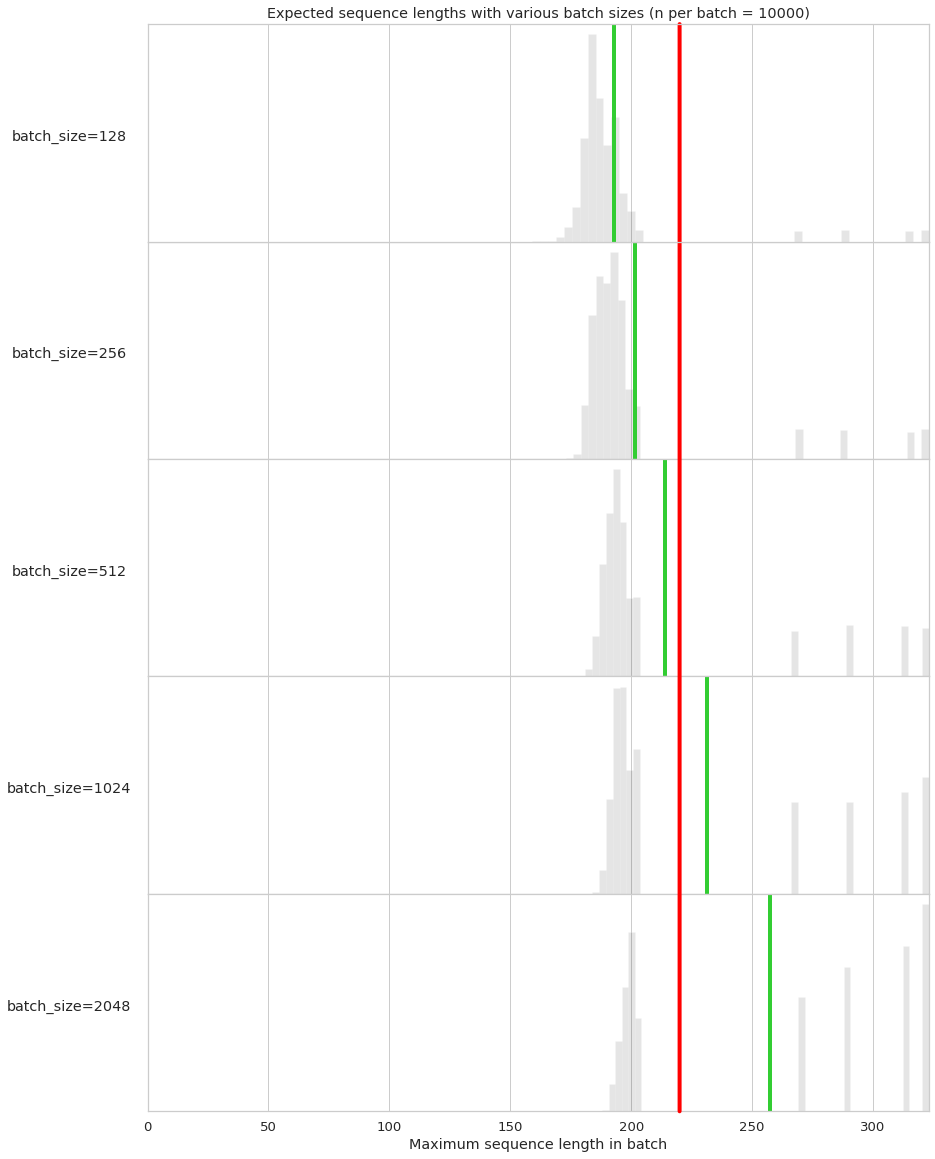

In [109]:
batch_sizes = [128, 256, 512, 1024, 2048]

expected_lengths = plot_expected_lengths(lengths, batch_sizes, lambda lengths: lengths.max(), markers=[MAX_LEN])
plt.xlabel('Maximum sequence length in batch')
print()

The expected batch length increases with the batch size. It even surpasses the maximum length of 220 at batch_size=32768, and it is significantly smaller than the fixed padding at a reasonable batch size e. g. 512. When looking at the historgram, you can also see very well that the number of outliers increases when increasing batch size. Because we are padding to the maximum length, the expected batch size is strongly influenced by outlier.

Note the the difference between the green line and the red line for each size does not directly relate to the speedup; there is some small overhead to dynamically padding the sequences.

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

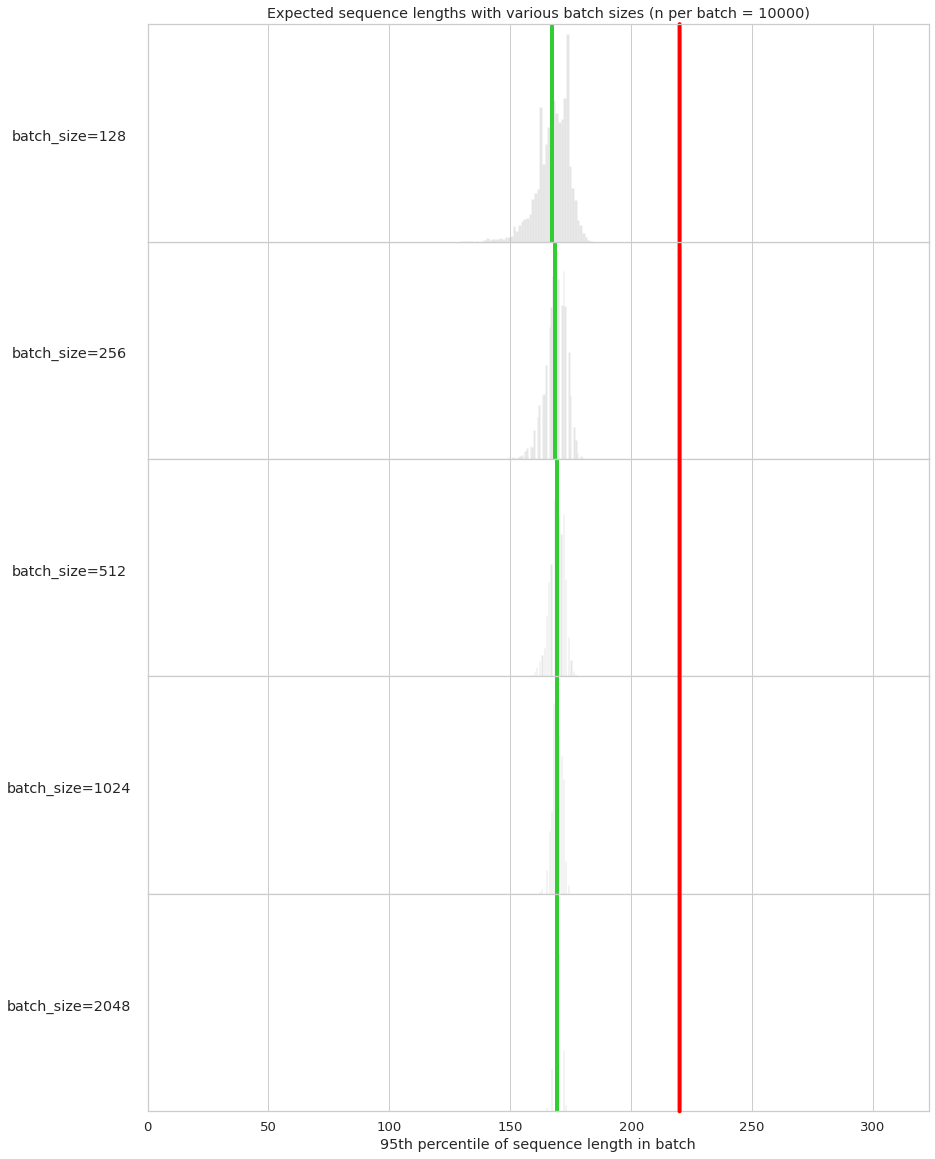

In [110]:
expected_lengths = plot_expected_lengths(lengths, batch_sizes, lambda lengths: np.percentile(lengths, q=95), markers=[MAX_LEN])
plt.xlabel('95th percentile of sequence length in batch')
print()

When padding to the 95th percentile of batch lengths instead, we can see another interesting pattern. The expected sequence length does not change that much when increasing batch size because it it more robust to outliers. In fact, it very quickly approaches the 95th percentile of lengths in the whole dataset!

In [111]:
np.percentile(lengths, q=95)

169.0

So it is questionable whether it makes sense to use sequence bucketing when padding to some percentile of the lengths for this dataset. We could just as well statically pad to the length at that percentile.

But it definitely does make sense if we want to get the last bit of performance out of our model and don't want to loose any information by truncating sequences. And it is still faster than the static padding of 220 with reasonably small batch sizes in that case.

# 2. Which method of sequence bucketing should I use?

I'm going to compare 3 methods:
1. Uses a custom dataset that stores the text as regular list with variable lengths and implements sequence bucketing in a `collate_fn` in the data loader.
2. The version I originally used in this kernel (version 1). Does sequence bucketing and splittng the data in batches on a dataset level. The data loader just always has a batch size of 1.
3. A new version which uses a `collate_fn` in the data loader to change already padded sequence to variable-ength batches. The dataset used is just a regular `TensorDataset`. Can be used as a drop-in replacement to static padding (and it is, as you'll see, the fastest).

The time it takes to iterate over the whole train dataset will be recorded for each of these methods when padding to the maximum length in a batch.

## 2.1 Method 1: TextDataset with collate_fn

A custom `collate_fn` is used in the DataLoader. The collate function takes a list of all samples in the batch as input and combines these to form one batch. This way, we can easily implement sequence bucketing in the data loader leaving the dataset untouched.

In [112]:
class TextDataset(data.Dataset):
    def __init__(self, text, lens, y=None):
        self.text = text
        self.lens = lens
        self.y = y

    def __len__(self):
        return len(self.lens)

    def __getitem__(self, idx):
        if self.y is None:
            return self.text[idx], self.lens[idx]
        return self.text[idx], self.lens[idx], self.y[idx]

class Collator(object):
    def __init__(self, test=False, percentile=100):
        self.test = test
        self.percentile = percentile

    def __call__(self, batch):
        global MAX_LEN

        if self.test:
            texts, lens = zip(*batch)
        else:
            texts, lens, target = zip(*batch)

        lens = np.array(lens)
        # 문장들의 최대길이가 MAX_LEN 보다 작다면, 그 값으로 패딩
        max_len = min(int(np.percentile(lens, self.percentile)), MAX_LEN)
        texts = torch.tensor(sequence.pad_sequences(texts, maxlen=max_len), dtype=torch.long)

        if self.test:
            return texts

        return texts, torch.tensor(target, dtype=torch.float32)

In [113]:
train_collate = Collator(percentile=100)
train_dataset = TextDataset(x_train, lengths, y_train_torch.numpy())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=Collator)

In [114]:
n_repeats = 10

start_time = time.time()
for _ in range(n_repeats):
    for t in tqdm(train_loader):
        pass
method1_time = (time.time() - start_time) / n_repeats

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

## 2.2 Method2: SequenceDataset with default loader

The method used in version 1 of this kernel. Uses a custom dataset to do all the work (sequence bucketing, splitting in batches, shuffling). The data loader then just has a batch size of 1.

In [115]:
class SequenceDataset(torch.utils.data.Dataset):
    """
    Dataset using sequence bucketing to pad each batch individually.
    
    Arguments:
        sequences (list): A list of variable length tokens (e. g. from keras tokenizer.texts_to_sequences)
        choose_length (function): A function which receives a numpy array of sequence lengths of one batch as input
                                  and returns the length this batch should be padded to.
        other_features (list, optional): A list of tensors with other features that should be fed to the NN alongside the sequences.
        labels (Tensor, optional): A tensor with labels for the samples.
        indices (np.array, optional): A numpy array consisting of indices to iterate over. 
        shuffle (bool): Whether to shuffle the dataset or not.  Default false.
        batch_size (int): Batch size of the samples. Default 512.
    
    implements: 
        train_dataset = SequenceDataset(x_train, lambda lengths: lengths.max(), other_features=[lengths], shuffle=False, batch_size=batch_size)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
    """

    def __init__(self, sequences, choose_length, other_features=None, labels=None,
                 indices=None, shuffle=False, batch_size=512):
        
        super(SequenceDataset, self).__init__()

        self.sequences = np.array(sequences)
        self.lengths = np.array([len(x) for x in sequences])
        self.n_samples = len(sequences)
        self.choose_length = choose_length
        self.other_features = other_features
        self.labels = labels

        if indices is not None:
            self.indices = indices
        else:
            self.indices = np.arange(len(sequences))
        
        self.batch_size = batch_size
        self.shuffle = shuffle

        if self.shuffle:
            self._shuffle()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def _shuffle(self):
        self.indices = np.random.permutation(self.indices)

    def __getitem__(self, i):
        idx = self.indices[(self.batch_size * i):(self.batch_size * (i+1))]

        if self.shuffle and i == len(self) - 1:
            self._shuffle()

        pad_length = math.ceil(self.choose_length(self.lengths[idx]))
        padded_sequences = sequence.pad_sequences(self.sequences[idx], maxlen=pad_length)

        x_batch = [torch.tensor(padded_sequences, dtype=torch.long)]

        if self.other_features is not None:
            x_batch += [x[idx] for x in self.other_features]

        if self.labels is not None:
            out = x_batch, self.labels[idx]
        else:
            out = x_batch
        
        return out

In [116]:
train_dataset = SequenceDataset(x_train, lambda lengths: lengths.max(), other_features=[lengths], shuffle=False, batch_size=BATCH_SIZE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [117]:
n_repeats = 10

start_time = time.time()
for _ in range(n_repeats):
    for batch in tqdm(train_loader):
        pass
method2_time = (time.time() - start_time) / n_repeats

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

## 2.3 Method3: Default TensorDataset with custom collate_fn

A new method using the DataLoader `collate_fn` for sequence bucketing that works with a regular `TensorDataset`.

In [118]:
lengths = torch.from_numpy(np.array([len(x) for x in x_train]))

maxlen = lengths.max() 
x_train_padded = torch.from_numpy(sequence.pad_sequences(x_train, maxlen=maxlen))
x_train_padded.shape

torch.Size([10000, 323])

In [119]:
class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None, maxlen=220):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        self.maxlen = maxlen

    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]

        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]

        length = self.choose_length(lengths)
        mask = torch.arange(start=self.maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]

        batch[self.sequence_index] = padded_sequences

        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch

In [120]:
dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE,
                               collate_fn=SequenceBucketCollator(torch.max, 0, 1, 2, maxlen=maxlen))

In [121]:
n_repeats = 10

start_time = time.time()
for _ in range(n_repeats):
    for batch in tqdm(train_loader):
        pass
method3_time = (time.time() - start_time) / n_repeats

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

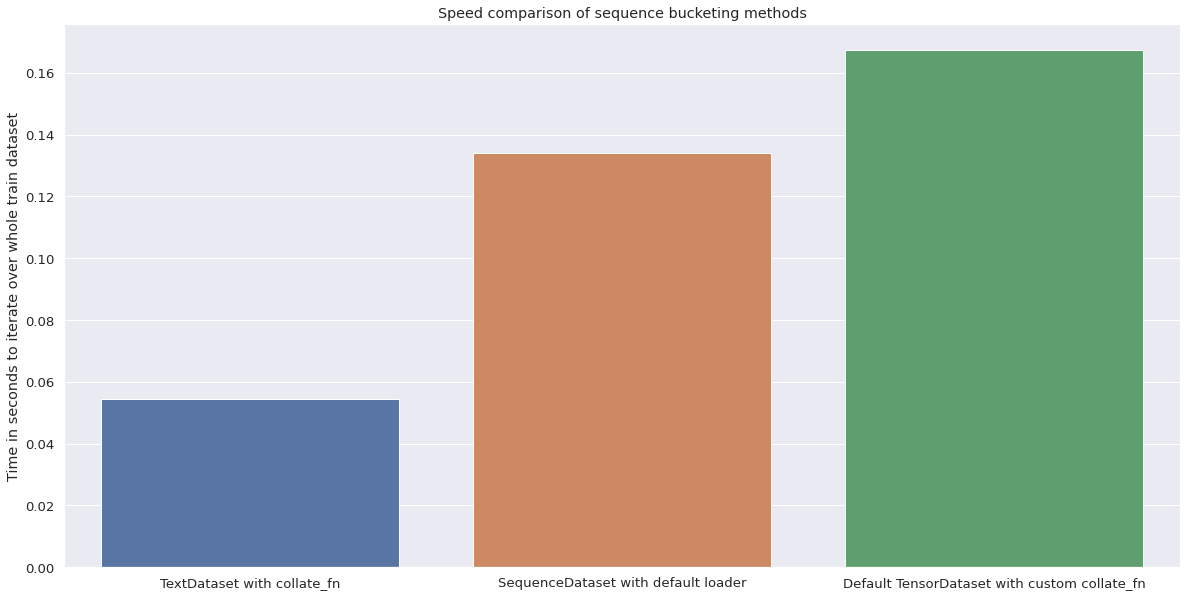

In [122]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
barplot = sns.barplot(x=[
    'TextDataset with collate_fn', 
    'SequenceDataset with default loader', 
    'Default TensorDataset with custom collate_fn'], y=[
    method1_time,
    method2_time,
    method3_time
])

plt.title('Speed comparison of sequence bucketing methods')
plt.ylabel('Time in seconds to iterate over whole train dataset')
print()

# 3. Implementation & comparing static padding with sequence bucketing

In [123]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)  # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

class NeuralNet(nn.Module):
    """
    For SequenceBucketCollator:
        The NN itself is also only slightly different.
        It also accepts an optional lengths parameter because lengths are part of the dataset now.
    """
    def __init__(self, lstm_units, dense_hidden_units, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]

        self.embedding = nn.Embedding(embedding_matrix.shape[0], embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)

        self.lstm1 = nn.LSTM(embed_size, lstm_units, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_units * 2, lstm_units, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(dense_hidden_units, dense_hidden_units)
        self.linear2 = nn.Linear(dense_hidden_units, dense_hidden_units)

        self.linear_out = nn.Linear(dense_hidden_units, 1)
        self.linear_aux_out = nn.Linear(dense_hidden_units, num_aux_targets)

    def forward(self, x, lengths=None):
        h_embedding = self.embedding(x.long())
        h_embedding = self.embedding_dropout(h_embedding)

        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)

        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)

        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1 = F.relu(self.linear1(h_conc))
        h_conc_linear2 = F.relu(self.linear2(h_conc))

        hidden = h_conc + h_conc_linear1 + h_conc_linear2

        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)

        return out

It's time for some benchmarks! I am going to compare the time it takes to predict the whole train dataset using:
- static padding (max_len=220)
- sequence bucketing (maximum length)
- static padding (to 95th percentile of lengths)
- sequence bucketing (to 95th percentile of lengths)

All with a batch size of 128. You can see the result below.

In [124]:
batch_size = 128

model = NeuralNet(LSTM_UNITS, DENSE_HIDDEN_UNITS, embedding_matrix, y_aux_train.shape[-1])
model.cuda()

# sequence bucketing - max length
train_dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
collator = SequenceBucketCollator(lambda lengths: lengths.max(), 0, 1, 2, maxlen=maxlen)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False, collate_fn=collator)

start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0][0].cuda())
max_length_seq_bucketing_time = time.time() - start_time

# sequence bucketing - 95th percentile of lenghts
train_dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
collator = SequenceBucketCollator(lambda lengths: np.percentile(lengths.numpy(), q=95), 0, 1, 2, maxlen=maxlen)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False, collate_fn=collator)
start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0][0].cuda())
percentile_seq_bucketing_time = time.time() - start_time

# static padding - maxlen of 220
x_train_padded = torch.tensor(sequence.pad_sequences(x_train, maxlen=MAX_LEN))
train_dataset = data.TensorDataset(x_train_padded)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0].cuda())
maxlen_static_time = time.time() - start_time

# static padding - 95th percentile
percentile_length = math.ceil(np.percentile(lengths, q=95))
x_train_padded = torch.tensor(sequence.pad_sequences(x_train, maxlen=percentile_length))
train_dataset = data.TensorDataset(x_train_padded)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0].cuda())
percentile_static_time = time.time() - start_time

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

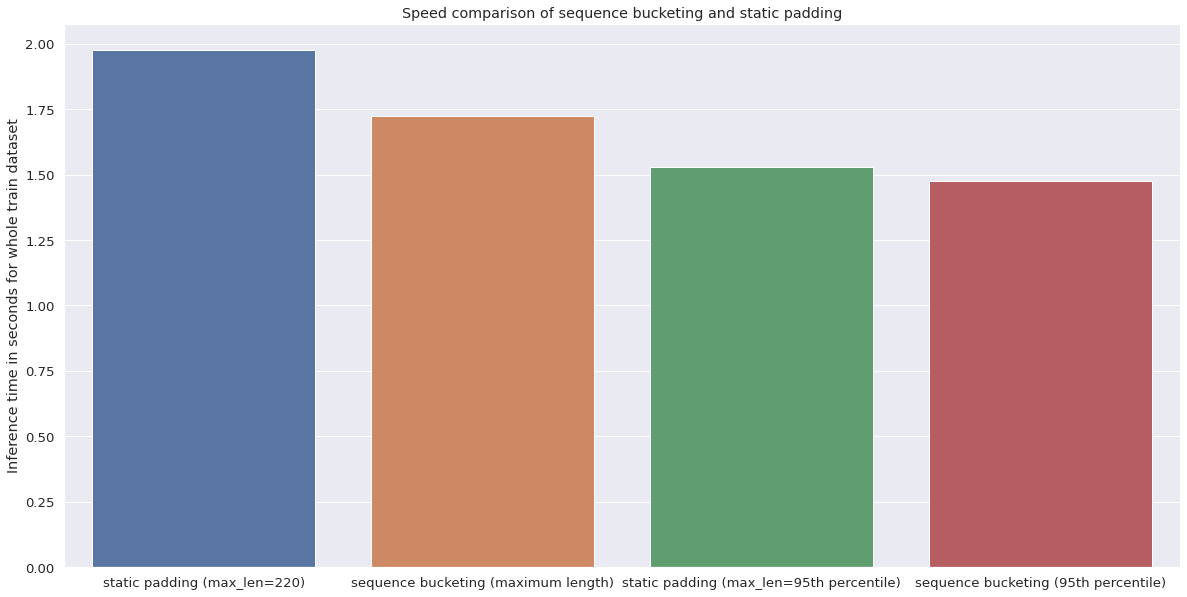

In [125]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
barplot = sns.barplot(x=[
    'static padding (max_len=220)', 
    'sequence bucketing (maximum length)', 
    'static padding (max_len=95th percentile)', 
    'sequence bucketing (95th percentile)'], y=[
    maxlen_static_time,
    max_length_seq_bucketing_time,
    percentile_static_time,
    percentile_seq_bucketing_time    
])

plt.title('Speed comparison of sequence bucketing and static padding')
plt.ylabel('Inference time in seconds for whole train dataset')
print()

# 4. Training

In [126]:
lengths = torch.from_numpy(np.array([len(x) for x in x_train]))
test_lengths = torch.from_numpy(np.array([len(x) for x in x_test]))
maxlen = lengths.max() 

x_train_padded = torch.from_numpy(sequence.pad_sequences(x_train, maxlen=maxlen))
x_test_padded = torch.from_numpy(sequence.pad_sequences(x_test, maxlen=maxlen))

In [127]:
batch_size = BATCH_SIZE

test_dataset = data.TensorDataset(x_test_padded, test_lengths)
train_dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
valid_dataset = data.Subset(train_dataset, indices=[0, 1])

train_collator = SequenceBucketCollator(torch.max, 
                                        sequence_index=0, 
                                        length_index=1, 
                                        label_index=2,
                                        maxlen=maxlen)
test_collator = SequenceBucketCollator(torch.max,
                                       sequence_index=0,
                                       length_index=1,
                                       maxlen=maxlen)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collator)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_collator)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_collator)

databunch = DataBunch(train_dl=train_loader, valid_dl=valid_loader, collate_fn=train_collator)

In [128]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:,1:2])(data[:,:1],targets[:,:1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:,1:],targets[:,2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2

In [129]:
all_test_preds = []

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    model = NeuralNet(LSTM_UNITS, DENSE_HIDDEN_UNITS, embedding_matrix, y_aux_train.shape[-1])
    learn = Learner(databunch, model, loss_func=custom_loss)
    test_preds = train_model(learn,test_dataset,output_dim=7)    
    all_test_preds.append(test_preds)

Model  0


epoch,train_loss,valid_loss,time
0,0.460557,0.064865,00:05


epoch,train_loss,valid_loss,time
0,0.294652,0.067549,00:05


epoch,train_loss,valid_loss,time
0,0.279141,0.067560,00:05


epoch,train_loss,valid_loss,time
0,0.245207,0.008253,00:05


Model  1


epoch,train_loss,valid_loss,time
0,0.431753,0.116176,00:05


epoch,train_loss,valid_loss,time
0,0.298620,0.027332,00:05


epoch,train_loss,valid_loss,time
0,0.279246,0.081369,00:05


epoch,train_loss,valid_loss,time
0,0.256320,0.036590,00:05
